In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score, fbeta_score, RocCurveDisplay
import shap


c:\Users\Phuah Kai Wen\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.chdir("C:/Users/Phuah Kai Wen/OneDrive/Documents/Coding/Python")

In [3]:
data = pd.read_csv("Data/loan.csv")

C:\Users\Phuah Kai Wen\AppData\Local\Temp\ipykernel_19924\3433887549.py:1: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Data/loan.csv")


In [4]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


In [6]:
data.isna().sum()

id                       2260668
member_id                2260668
loan_amnt                      0
funded_amnt                    0
funded_amnt_inv                0
                          ...   
settlement_status        2227612
settlement_date          2227612
settlement_amount        2227612
settlement_percentage    2227612
settlement_term          2227612
Length: 145, dtype: int64

Identifying the Target Variable

In [7]:
loan_status_mapping = {
    "Fully Paid": 1,
    "Current": 1,
    "In Grace Period": 1,
    "Default": 0,
    "Charged Off": 0,
    "Late (31-120 days)": 0,
    "Late (16-30 days)": 0
}

data["loan_status_new"] = data["loan_status"].map(loan_status_mapping)

In [8]:
data.drop("loan_status", axis = 1, inplace = True)

In [9]:
data["loan_status_new"].value_counts()

loan_status_new
1.0    1970599
0.0     287320
Name: count, dtype: int64

In [10]:
data.dropna(subset=["loan_status_new"], inplace = True)

In [11]:
data["loan_status_new"].isna().sum()

0

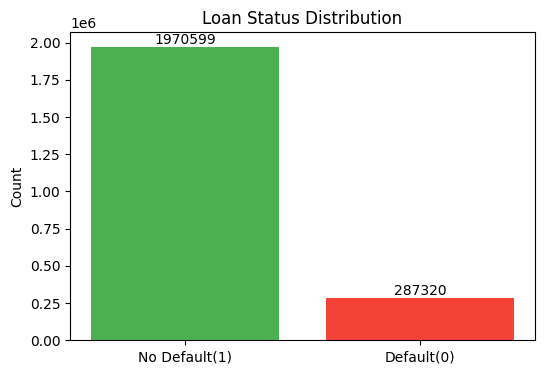

In [12]:
labels = ["No Default(1)", "Default(0)"]
values = [data["loan_status_new"].value_counts()[1],
          data["loan_status_new"].value_counts()[0]]

fig, ax = plt.subplots(figsize = (6,4))
bars = ax.bar(labels, values, color = ["#4CAF50", "#F44336"])
ax.set_title("Loan Status Distribution")
ax.set_ylabel("Count")

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height,
            f'{height}', ha='center', va='bottom')

plt.show() 


In [13]:
data.isna().sum()

id                       2257919
member_id                2257919
loan_amnt                      0
funded_amnt                    0
funded_amnt_inv                0
                          ...   
settlement_date          2224873
settlement_amount        2224873
settlement_percentage    2224873
settlement_term          2224873
loan_status_new                0
Length: 145, dtype: int64

Working with Missing Value

Removing columns where missing value is larger than 50%

In [14]:
def missing_data_summary(df, threshold):
    return (pd.DataFrame(data.isna().sum())
            .reset_index()
            .rename(columns = {"index" : "Columns", 0 : "Missing_Values"})
            .query("Missing_Values > 0")
            .assign(Missing_Values_Percentage = lambda x : x["Missing_Values"] / data.shape[0] * 100)
            .query(f"Missing_Values_Percentage > {threshold}")
            .sort_values("Missing_Values", ascending = False)
            .reset_index(drop = True)
    )

In [15]:
md = missing_data_summary(data, 50)

In [16]:
md

,Columns,Missing_Values,Missing_Values_Percentage
0,id,2257919,100.000000
1,url,2257919,100.000000
2,member_id,2257919,100.000000
3,orig_projected_additional_accrued_interest,2249493,99.626825
4,hardship_length,2247306,99.529965
5,hardship_reason,2247306,99.529965
6,hardship_status,2247306,99.529965
7,deferral_term,2247306,99.529965
8,hardship_amount,2247306,99.529965
9,hardship_start_date,2247306,99.529965


In [17]:
columns_drop = md.iloc[:, 0].to_list()
data.drop(columns_drop, axis = 1, errors = "ignore", inplace = True)

In [18]:
data

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,loan_status_new
0,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,...,1.0,0.0,60124.0,16901.0,36500.0,18124.0,N,Cash,N,1.0
1,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,...,1.0,0.0,372872.0,99468.0,15000.0,94072.0,N,Cash,N,1.0
2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,...,0.0,0.0,136927.0,11749.0,13800.0,10000.0,N,Cash,N,1.0
3,4000,4000,4000.0,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,...,0.0,0.0,385183.0,36151.0,5000.0,44984.0,N,Cash,N,1.0
4,30000,30000,30000.0,60 months,16.14,731.78,C,C4,Mechanic,10+ years,...,0.0,0.0,157548.0,29674.0,9300.0,32332.0,N,Cash,N,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260663,12000,12000,12000.0,60 months,14.08,279.72,C,C3,house keeper,10+ years,...,0.0,0.0,73948.0,45212.0,6200.0,49448.0,N,Cash,N,1.0
2260664,12000,12000,12000.0,60 months,25.82,358.01,E,E4,Skilled Labor,< 1 year,...,0.0,0.0,382275.0,12928.0,11400.0,12125.0,N,Cash,N,1.0
2260665,10000,10000,10000.0,36 months,11.99,332.10,B,B5,Teacher,10+ years,...,0.0,0.0,203417.0,36448.0,2000.0,29317.0,N,Cash,N,1.0
2260666,12000,12000,12000.0,60 months,21.45,327.69,D,D5,NaN,NaN,...,0.0,0.0,118975.0,65238.0,22000.0,81975.0,N,Cash,N,1.0


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2257919 entries, 0 to 2260667
Columns: 101 entries, loan_amnt to loan_status_new
dtypes: float64(76), int64(4), object(21)
memory usage: 1.7+ GB


Inspecting Categorical Columns

In [20]:
data.select_dtypes(include = ["object"]).head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,purpose,...,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,36 months,C,C1,Chef,10+ years,RENT,Not Verified,Dec-2018,n,debt_consolidation,...,109xx,NY,Apr-2001,w,Feb-2019,Feb-2019,Individual,N,Cash,N
1,60 months,D,D2,Postmaster,10+ years,MORTGAGE,Source Verified,Dec-2018,n,debt_consolidation,...,713xx,LA,Jun-1987,w,Feb-2019,Feb-2019,Individual,N,Cash,N
2,36 months,D,D1,Administrative,6 years,MORTGAGE,Source Verified,Dec-2018,n,debt_consolidation,...,490xx,MI,Apr-2011,w,Feb-2019,Feb-2019,Individual,N,Cash,N
3,36 months,D,D2,IT Supervisor,10+ years,MORTGAGE,Source Verified,Dec-2018,n,debt_consolidation,...,985xx,WA,Feb-2006,w,Feb-2019,Feb-2019,Individual,N,Cash,N
4,60 months,C,C4,Mechanic,10+ years,MORTGAGE,Not Verified,Dec-2018,n,debt_consolidation,...,212xx,MD,Dec-2000,w,Feb-2019,Feb-2019,Individual,N,Cash,N


Clean String Columns

In [21]:
data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

Converting Date Columns

In [22]:
data.select_dtypes(include = ["datetime64"]).columns

Index([], dtype='object')

In [23]:
data["issue_d"] = pd.to_datetime(data["issue_d"], format = "%b-%Y")
data["earliest_cr_line"] = pd.to_datetime(data["earliest_cr_line"], format = "%b-%Y")
data["last_pymnt_d"] = pd.to_datetime(data["last_pymnt_d"], format = "%b-%Y")
data["last_credit_pull_d"] = pd.to_datetime(data["last_credit_pull_d"], format = "%b-%Y")

Term and Employee Length Cleaning

In [24]:
data["term"].value_counts()

term
36 months    1607316
60 months     650603
Name: count, dtype: int64

In [25]:
data["emp_length"].value_counts()

emp_length
10+ years    747535
2 years      203328
< 1 year     189516
3 years      180487
1 year       148055
5 years      139526
4 years      136400
6 years      102484
7 years       92595
8 years       91807
9 years       79313
Name: count, dtype: int64

In [26]:
cols = ["emp_length", "term"]

for i in cols:
    data[i] = data[i].fillna("")
    data[i] = pd.to_numeric(data[i].str.replace(r"[^0-9]", "", regex = True), errors = "coerce")

Normalizing Hardship Flag and Debt Settlement Flag

In [27]:
data["debt_settlement_flag"].value_counts()

debt_settlement_flag
N    2224873
Y      33046
Name: count, dtype: int64

In [28]:
data["hardship_flag"].value_counts()

hardship_flag
N    2257034
Y        885
Name: count, dtype: int64

In [29]:
col = ["hardship_flag", "debt_settlement_flag"]
for i in col:
    data[i] = data[i].map({"N": 0 , "Y" : 1})

Dropping Columns that will not be Used

In [30]:
columns_drop = ["pymnt_plan", "zip_code", "addr_state", "emp_title", "title"]
data.drop(columns_drop, axis = 1, inplace = True)

Count Unique Categories

In [31]:
def get_sorted_unique_counts(data):
    object_cols = data.select_dtypes(include = ["object", "category"]).columns
    object_nunique =  {col : data[col].nunique()for col in object_cols}
    unique_counts = pd.DataFrame(list(object_nunique.items()), columns = ["Column", "Unique_Count"])
    unique_counts = unique_counts.sort_values(by = "Unique_Count", ascending = False).reset_index(drop = True)
    return unique_counts

get_sorted_unique_counts(data)


,Column,Unique_Count
0,sub_grade,35
1,purpose,14
2,grade,7
3,home_ownership,6
4,verification_status,3
5,initial_list_status,2
6,application_type,2
7,disbursement_method,2


C:\Users\Phuah Kai Wen\AppData\Local\Temp\ipykernel_19924\2003683030.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation = 45)


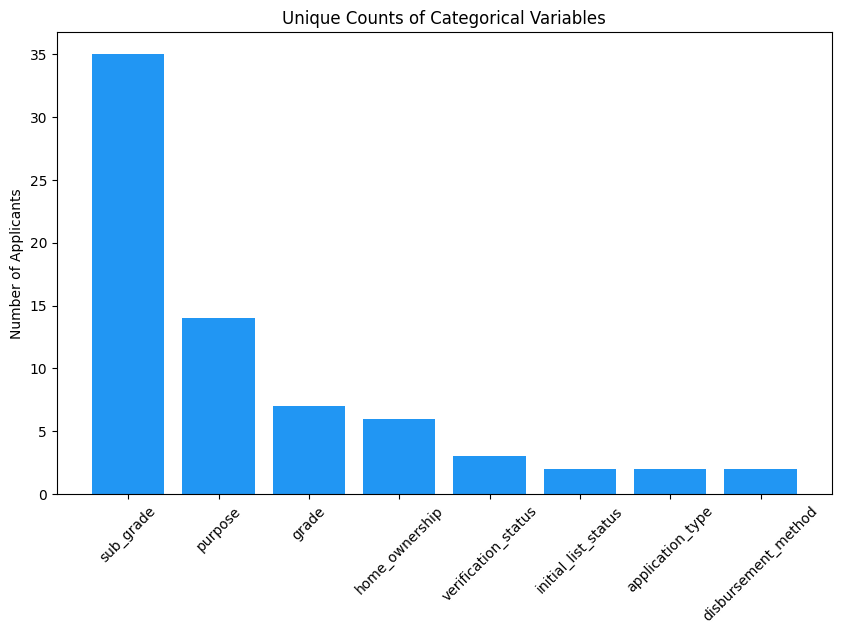

In [32]:
unique_counts = get_sorted_unique_counts(data)

labels = unique_counts["Column"].tolist()
values = unique_counts["Unique_Count"].tolist()

fig, ax = plt.subplots(figsize = (10,6))
bars = ax.bar(labels, values, color = "#2196F3")
ax.set_title("Unique Counts of Categorical Variables")
ax.set_ylabel("Number of Applicants")
ax.set_xticklabels(labels, rotation = 45)
plt.show()




Investigating Categories inside sub_grade

In [33]:
data["sub_grade"].value_counts().sort_index()

sub_grade
A1     86787
A2     69550
A3     73171
A4     95855
A5    107566
B1    125289
B2    126566
B3    131441
B4    139717
B5    140190
C1    145781
C2    130973
C3    129064
C4    126983
C5    116623
D1     81665
D2     72766
D3     64675
D4     56742
D5     47885
E1     33457
E2     29792
E3     26596
E4     22666
E5     22592
F1     13350
F2      9248
F3      7742
F4      6082
F5      5131
G1      4070
G2      2659
G3      2064
G4      1669
G5      1512
Name: count, dtype: int64

In [34]:
for col in data.select_dtypes(include = ["object"]).columns:
    print(data[col].value_counts().sort_index())

grade
A    432929
B    663203
C    649424
D    323733
E    135103
F     41553
G     11974
Name: count, dtype: int64
sub_grade
A1     86787
A2     69550
A3     73171
A4     95855
A5    107566
B1    125289
B2    126566
B3    131441
B4    139717
B5    140190
C1    145781
C2    130973
C3    129064
C4    126983
C5    116623
D1     81665
D2     72766
D3     64675
D4     56742
D5     47885
E1     33457
E2     29792
E3     26596
E4     22666
E5     22592
F1     13350
F2      9248
F3      7742
F4      6082
F5      5131
G1      4070
G2      2659
G3      2064
G4      1669
G5      1512
Name: count, dtype: int64
home_ownership
ANY             996
MORTGAGE    1110194
NONE             49
OTHER           144
OWN          252870
RENT         893666
Name: count, dtype: int64
verification_status
Not Verified       742974
Source Verified    885941
Verified           629004
Name: count, dtype: int64
purpose
car                     23949
credit_card            516631
debt_consolidation    1276777
educationa

Observations:
Due to a Huge Number of Unique Values Appearing in sub_grade and it is already hierarchically grouped via grade, the column is redundant and will be dropped from the dataset

In [35]:
data.drop("sub_grade", axis = 1, inplace = True)

Using WoE & IV for categorical features¶

In [36]:
def process_categorical_columns(data, categorical_cols, target_col, woe_table = None, iv_summary = None, append = False):

    if append and (woe_table is None or iv_summary is None):
        raise ValueError("Existing tables must be provided when append is set to True.")
    
    if not append:
        woe_table = pd.DataFrame()
        iv_summary = pd.DataFrame()

    new_woe_results = []
    new_summary = []

    for col in categorical_cols:
        data[col] = data[col].fillna("NaN")

        stats = data.groupby(col).agg(
            event_count = (target_col,  "sum"),
            total_count = (target_col, "count")
        ).reset_index()
        
        stats["non_event_count"] = stats["total_count"] - stats["event_count"]
        total_events = stats["event_count"].sum()
        total_non_events = stats["non_event_count"].sum()

        stats["event_rate"] = stats["event_count"] / (total_events + 1e-6)
        stats["non_event_rate"] = stats["non_event_count"] / (total_non_events + 1e-6)

        stats["woe"] = np.log((stats["non_event_rate"]+ 1e-6) / (stats["event_rate"] + 1e-6))
        stats["iv"] = (stats["non_event_rate"] - stats["event_rate"]) * stats["woe"]
        total_iv = stats['iv'].sum()

        stats["name"] = col
        stats.rename(columns = {col: "sub_name"}, inplace = True)

        stats = stats[['name', 'sub_name', 'event_count', 'total_count', 'non_event_count', 
                       'event_rate', 'non_event_rate', 'woe', 'iv']]
        
        new_woe_results.append(stats)
        new_summary.append({"Column": col, "IV": total_iv})
    
    new_woe_table = pd.concat(new_woe_results, ignore_index = True)
    new_iv_summary = pd.DataFrame(new_summary).sort_values(by = "IV", ascending = False)

    if append:
        woe_table = pd.concat([woe_table, new_woe_table], ignore_index =  True)
        iv_summary = pd.concat([iv_summary, new_iv_summary], ignore_index = True).sort_values(by = "IV", ascending = False)
    else:
        woe_table = new_woe_table
        iv_summary = new_iv_summary
    

    return woe_table, iv_summary


In [37]:
categorical_cols = data.select_dtypes(include = ["object"]).columns

woe_table, iv_summary = process_categorical_columns(data, categorical_cols, "loan_status_new")

In [38]:
iv_summary.reset_index(drop = True, inplace = True)
iv_summary

,Column,IV
0,grade,0.479653
1,verification_status,0.085739
2,disbursement_method,0.060555
3,initial_list_status,0.034924
4,home_ownership,0.024762
5,purpose,0.023014
6,application_type,0.019782


In [39]:
# Interpretation of IV:
# < 0.02: Not Predictive
# 0.02 - 0.1: Weak Predictive Power
# 0.1 - 0.3: Medium Predictive Power
# 0.3+: Strong Predictive Power
# IV > 0.5: Suspiciously strong — Could indicate overfitting or data issues.

Dropping Application_type Column

In [40]:
data.drop("application_type", axis = 1, inplace = True)

In [41]:
print("WoE Table for Grade:")
woe_table[woe_table["name"] == "grade"]


WoE Table for Grade:


,name,sub_name,event_count,total_count,non_event_count,event_rate,non_event_rate,woe,iv
0,grade,A,417580.0,432929,15349.0,0.211905,0.053421,-1.377916,0.218377
1,grade,B,606538.0,663203,56665.0,0.307794,0.197219,-0.445113,0.049218
2,grade,C,557186.0,649424,92238.0,0.282750,0.321029,0.126969,0.004860
3,grade,D,258470.0,323733,65263.0,0.131163,0.227144,0.549139,0.052707
4,grade,E,97174.0,135103,37929.0,0.049312,0.132010,0.984696,0.081432
5,grade,F,26456.0,41553,15097.0,0.013425,0.052544,1.364454,0.053376
6,grade,G,7195.0,11974,4779.0,0.003651,0.016633,1.516128,0.019682


In [42]:
print("WoE Table for Verification_Status:")
woe_table[woe_table["name"] == "verification_status"]


WoE Table for Verification_Status:


,name,sub_name,event_count,total_count,non_event_count,event_rate,non_event_rate,woe,iv
13,verification_status,Not Verified,678532.0,742974,64442.0,0.344328,0.224287,-0.428668,0.051458
14,verification_status,Source Verified,768830.0,885941,117111.0,0.390150,0.407598,0.043748,0.000763
15,verification_status,Verified,523237.0,629004,105767.0,0.265522,0.368116,0.326699,0.033517


In [43]:
print("WoE Table for Disbursement_Method:")
woe_table[woe_table["name"] == "disbursement_method"]

WoE Table for Disbursement_Method:


,name,sub_name,event_count,total_count,non_event_count,event_rate,non_event_rate,woe,iv
34,disbursement_method,Cash,1894264.0,2179797,285533.0,0.961263,0.99378,0.033268,0.001082
35,disbursement_method,DirectPay,76335.0,78122,1787.0,0.038737,0.00622,-1.828962,0.059473


In [44]:
print("WoE Table for initial_list_status:")
woe_table[woe_table["name"] == "initial_list_status"]

WoE Table for initial_list_status:


,name,sub_name,event_count,total_count,non_event_count,event_rate,non_event_rate,woe,iv
30,initial_list_status,f,608167.0,722452,114285.0,0.30862,0.397762,0.253741,0.022619
31,initial_list_status,w,1362432.0,1535467,173035.0,0.69138,0.602238,-0.138036,0.012305


In [45]:
print("WoE Table for Home_Ownership:")
woe_table[woe_table["name"] == "home_ownership"]

WoE Table for Home_Ownership:


,name,sub_name,event_count,total_count,non_event_count,event_rate,non_event_rate,woe,iv
7,home_ownership,ANY,928.0,996,68.0,0.000471,0.000237,-0.685933,1.606817e-04
8,home_ownership,MORTGAGE,987389.0,1110194,122805.0,0.501060,0.427415,-0.158970,1.170731e-02
9,home_ownership,NONE,42.0,49,7.0,0.000021,0.000024,0.128111,3.907079e-07
10,home_ownership,OTHER,117.0,144,27.0,0.000059,0.000094,0.453042,1.567483e-05
11,home_ownership,OWN,220666.0,252870,32204.0,0.111979,0.112084,0.000937,9.829256e-08
12,home_ownership,RENT,761457.0,893666,132209.0,0.386409,0.460145,0.174646,1.287781e-02


In [46]:
print("WoE Table for Purpose:")
woe_table[woe_table["name"] == "purpose"]

WoE Table for Purpose:


,name,sub_name,event_count,total_count,non_event_count,event_rate,non_event_rate,woe,iv
16,purpose,car,21637.0,23949,2312.0,0.010980,0.008047,-0.310762,0.000912
17,purpose,credit_card,463192.0,516631,53439.0,0.235051,0.185991,-0.234103,0.011485
18,purpose,debt_consolidation,1100905.0,1276777,175872.0,0.558665,0.612112,0.091365,0.004883
19,purpose,educational,271.0,327,56.0,0.000138,0.000195,0.346601,0.000020
20,purpose,home_improvement,133457.0,150243,16786.0,0.067724,0.058423,-0.147736,0.001374
21,purpose,house,12333.0,14092,1759.0,0.006259,0.006122,-0.022033,0.000003
22,purpose,major_purchase,44345.0,50322,5977.0,0.022503,0.020803,-0.078581,0.000134
23,purpose,medical,23766.0,27430,3664.0,0.012060,0.012752,0.055791,0.000039
24,purpose,moving,12995.0,15357,2362.0,0.006594,0.008221,0.220410,0.000358
25,purpose,other,121193.0,139016,17823.0,0.061501,0.062032,0.008602,0.000005


From the woe_table, we can see that the both home_ownership and purpose has multiple rarely used categories. To prevent the categories from increasing model variance, it will be grouped into a single category under "other".

In [47]:
home_ownership_map = {
    "ANY": "other",
    "NONE": "other",
    "MORTGAGE": "mortgage",
    "RENT": "rent",
    "OWN": "own"
}

data["home_ownership"] = data["home_ownership"].map(home_ownership_map)

In [48]:
data["home_ownership"].value_counts()

home_ownership
mortgage    1110194
rent         893666
own          252870
other          1045
Name: count, dtype: int64

In [49]:
purpose_map = {
    "car": "car",
    "wedding": "other",
    "educational": "other",
    "house_improvement": "house_improvement",
    "renewable_energy": "other",
    "vacation": "other",
    "house": "house_improvement",
    "small_business": "small_business",
    "major_purchase": "major_purchase",
    "medical": "other",
    "moving": "other",
    "debt_consolidation": "debt_consolidation",
    "credit_card": "credit_card"
}

data["purpose"] = data["purpose"].map(purpose_map)

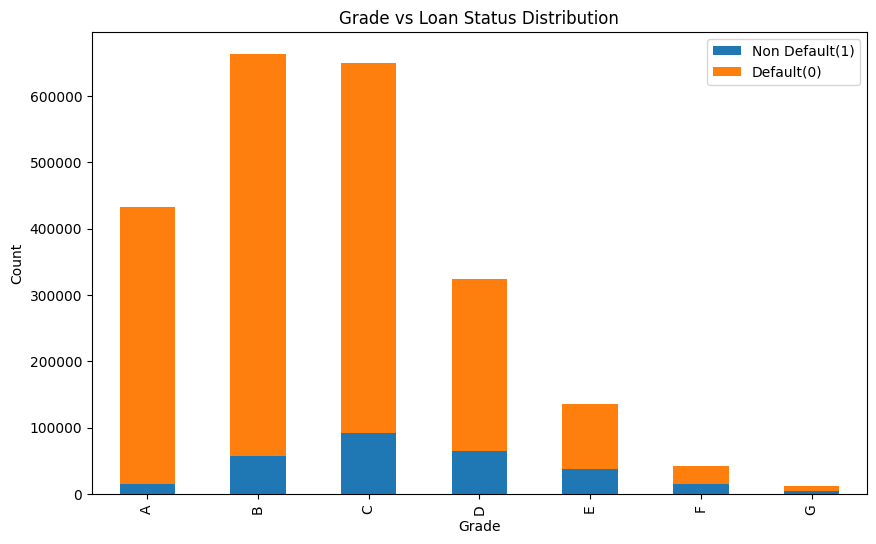

In [50]:
counts = data.groupby(["grade", "loan_status_new"]).size().unstack(fill_value = 0)

counts.plot(kind = "bar", stacked = True, figsize = (10,6))

plt.xlabel("Grade")
plt.ylabel("Count")
plt.title("Grade vs Loan Status Distribution")
plt.legend(["Non Default(1)", "Default(0)"])
plt.show()

In [51]:
counts = data.groupby(["verification_status", "loan_status_new"]).size().unstack(fill_value = 0)


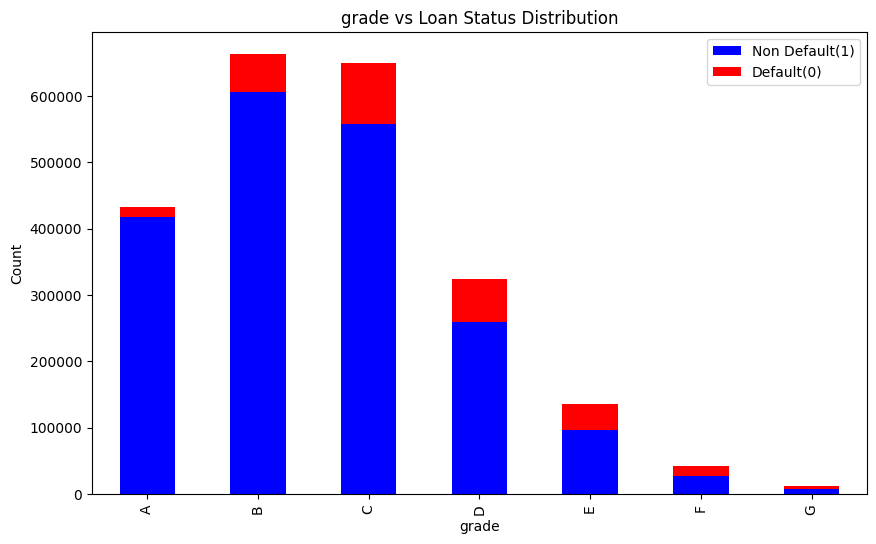

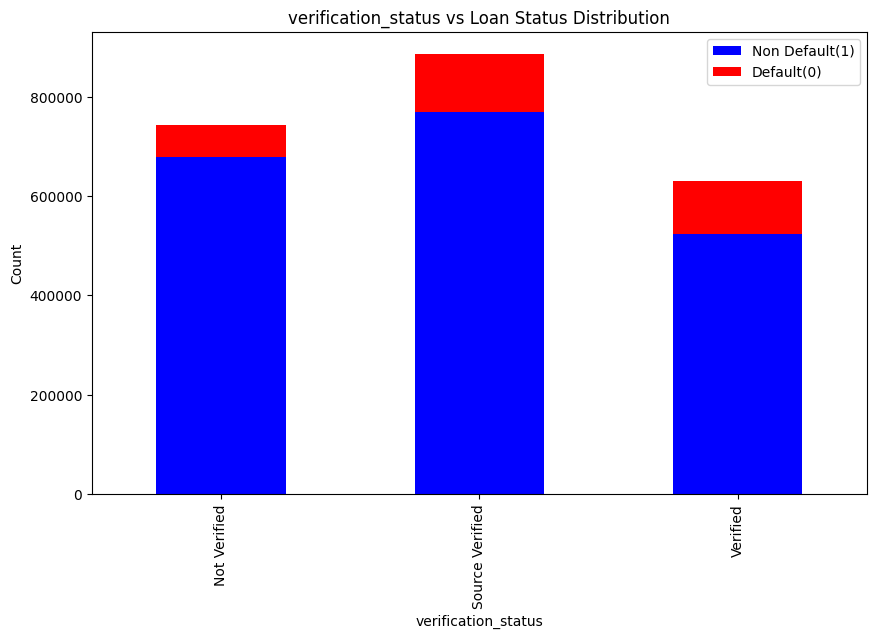

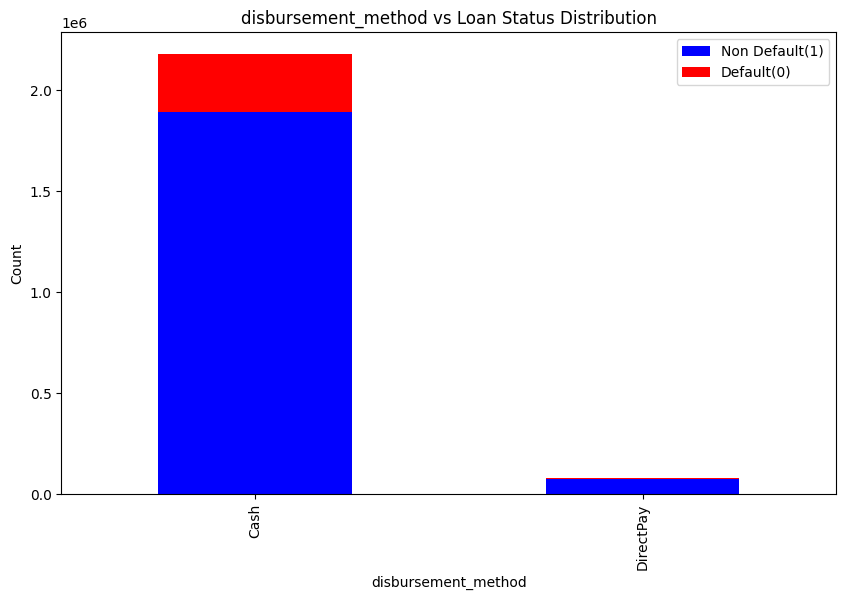

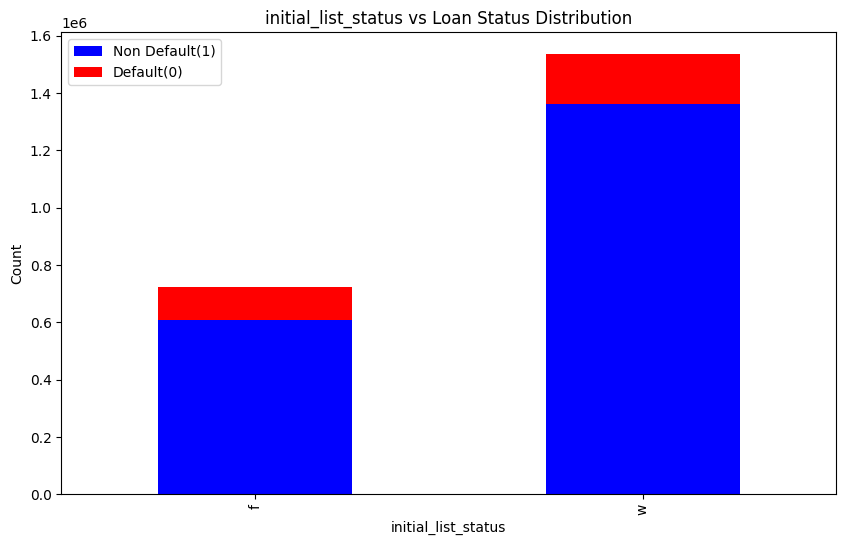

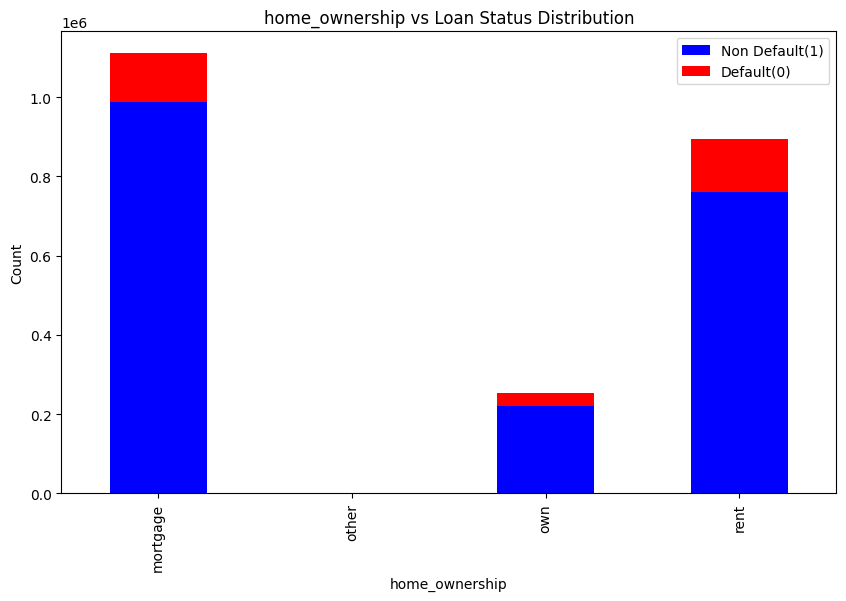

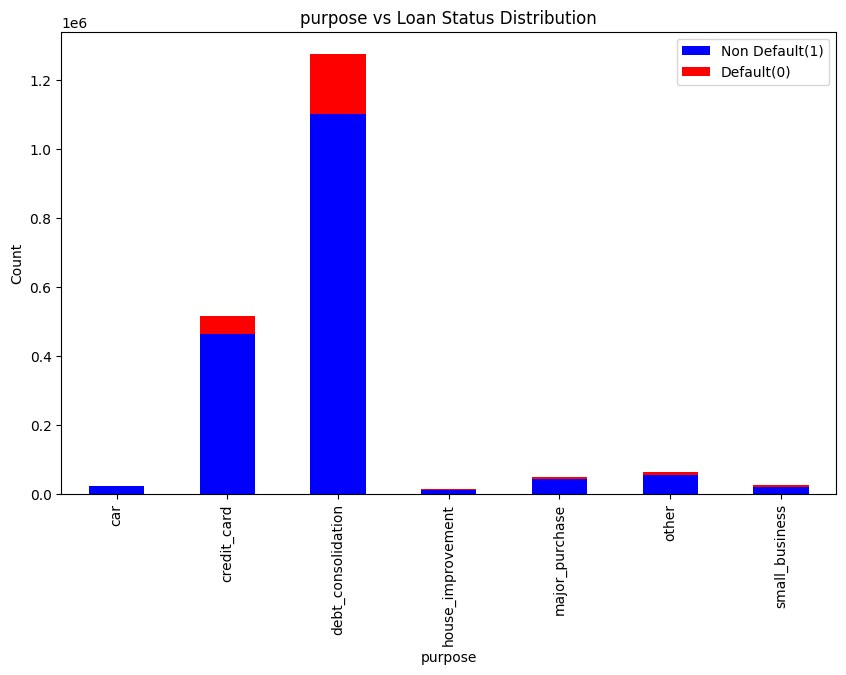

In [52]:
list = ["grade", "verification_status", "disbursement_method", "initial_list_status", "home_ownership", "purpose"]

for i in list:
    count = data.groupby([i, "loan_status_new"]).size().unstack(fill_value = 0)
    count = count[[1, 0]]
    count.plot(kind = "bar", stacked = True, figsize = (10,6), color = ["#0000FF", "#FF0000"])


    plt.xlabel(i)
    plt.ylabel("Count")
    plt.title(f"{i} vs Loan Status Distribution")
    plt.legend(["Non Default(1)", "Default(0)"])
    plt.show()

Date Features

In [53]:
date_cols = data.select_dtypes(include = ["datetime64"]).columns
data[date_cols].head()

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,2018-12-01,2001-04-01,2019-02-01,2019-02-01
1,2018-12-01,1987-06-01,2019-02-01,2019-02-01
2,2018-12-01,2011-04-01,2019-02-01,2019-02-01
3,2018-12-01,2006-02-01,2019-02-01,2019-02-01
4,2018-12-01,2000-12-01,2019-02-01,2019-02-01


In [54]:
data[date_cols].isna().sum()

issue_d                  0
earliest_cr_line         0
last_pymnt_d          2414
last_credit_pull_d      71
dtype: int64

Replacing missing values with todays date

In [55]:
today = pd.to_datetime("today")
data[["earliest_cr_line", "issue_d", "last_pymnt_d", "last_credit_pull_d"]].fillna(today, inplace = True)

C:\Users\Phuah Kai Wen\AppData\Local\Temp\ipykernel_19924\2138699267.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[["earliest_cr_line", "issue_d", "last_pymnt_d", "last_credit_pull_d"]].fillna(today, inplace = True)


Creating New Columns from Existing Data

In [56]:
data["loan_age"] = (today - data["issue_d"]).dt.days
data["credit_history_length"] = (data["issue_d"] - data["earliest_cr_line"]).dt.days
data["time_since_last_payment"] = (today - data["last_pymnt_d"]).dt.days
data["time_since_last_credit_pull"] = (today - data["last_credit_pull_d"]).dt.days

Extracting Month and Years to capture seasonality behaviour

In [57]:
data["issue_year"] = data["issue_d"].dt.year
data["issue_month"] = data["issue_d"].dt.month

Create Categorical Flags

In [58]:
data["recent_payment"] = (data["time_since_last_payment"] <=30).astype(int)
data["recent_credit_pull"] = (data["time_since_last_credit_pull"] <=90).astype(int)

In [59]:
drop_cols = {"earliest_cr_line", "issue_d", "last_pymnt_d", "last_credit_pull_d"}
data.drop(drop_cols, axis = 1, inplace = True)

Numeric Features

In [60]:
y = data["loan_status_new"]

In [61]:
y.isna().sum()

0

In [62]:
cat_cols = data.select_dtypes(include = ["object"]).columns
num_cols = data.select_dtypes(exclude = ["object"]).drop("loan_status_new", axis = 1).columns

In [63]:
final_data = pd.concat([data[num_cols], pd.get_dummies(data[cat_cols], drop_first = True)], axis = 1)

Replacing missing numeric values with mean value

In [64]:
imputer = SimpleImputer(strategy = "mean")
X_imputed = imputer.fit_transform(final_data)
final_data = pd.DataFrame(X_imputed, columns = final_data.columns)

Correlation Analysis between Features and Target

In [65]:
correlations = final_data.corrwith(y).abs().sort_values(ascending = False).reset_index()

c:\Users\Phuah Kai Wen\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Phuah Kai Wen\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Phuah Kai Wen\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Phuah Kai Wen\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Phuah Kai Wen\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Phuah Kai Wen\AppData\Local\Programs\Python\Py

In [66]:
correlations.columns = ["name", "correlation"]

In [67]:
correlations.head(30)

,name,correlation
0,recoveries,0.482490
1,collection_recovery_fee,0.458173
2,debt_settlement_flag,0.314430
3,time_since_last_payment,0.222173
4,total_rec_prncp,0.216233
5,int_rate,0.198681
6,time_since_last_credit_pull,0.184561
7,last_pymnt_amnt,0.180653
8,out_prncp,0.168415
9,out_prncp_inv,0.168400


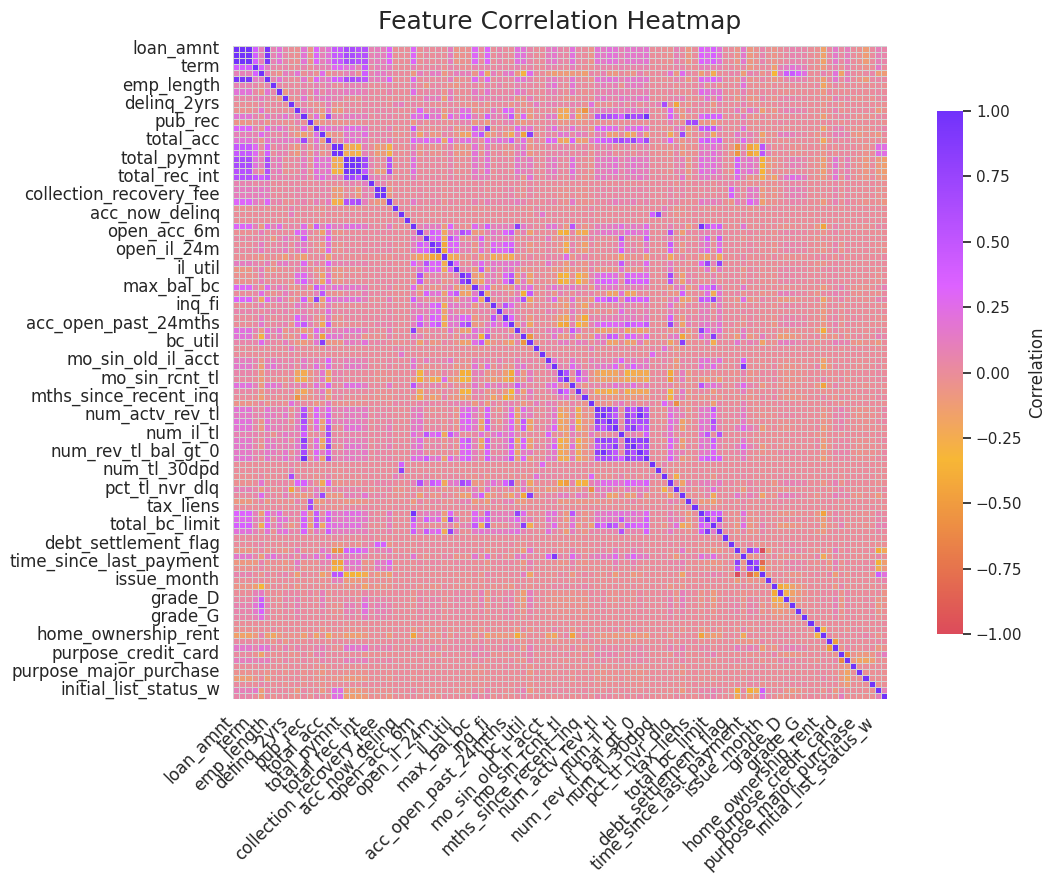

In [68]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


colors = ["#dc4b5b", "#f7b736", "#dd62ff", "#7132fb"]
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", colors, N=256)


feature_corr = final_data.corr()


mask = (feature_corr.abs() > 0.4).any(axis=1)
filtered_corr = feature_corr.loc[mask, mask]


plt.figure(figsize=(12, 9))
sns.set(font="DejaVu Sans", style="white", rc={"axes.facecolor": "white"})

sns.heatmap(
    filtered_corr,
    cmap=custom_cmap,
    center=0,
    linewidths=0.5,
    linecolor='lightgray',
    square=True,
    annot=False,
    cbar_kws={'shrink': 0.8, 'label': 'Correlation'},
    vmin=-1, vmax=1
)

plt.title("Feature Correlation Heatmap", fontsize=18, pad=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize
=12)
plt.tight_layout()
plt.show()

Correlation Analysis between Features

In [69]:
high_corr_pairs = feature_corr.abs().unstack().reset_index()

In [70]:
high_corr_pairs = high_corr_pairs[high_corr_pairs["level_0"] != high_corr_pairs["level_1"]]

In [71]:
high_corr_pairs.columns = ["feature_1", "feature_2", "correlation"]

In [72]:
threshold = 0.8
high_corr_pairs = high_corr_pairs[high_corr_pairs["correlation"]> threshold]

In [73]:
high_corr_pairs

,feature_1,feature_2,correlation
1,loan_amnt,funded_amnt,0.999764
2,loan_amnt,funded_amnt_inv,0.999228
5,loan_amnt,installment,0.945600
110,funded_amnt,loan_amnt,0.999764
112,funded_amnt,funded_amnt_inv,0.999513
...,...,...,...
9293,credit_history_length,mo_sin_old_rev_tl_op,0.903511
9433,time_since_last_payment,loan_age,0.813641
9437,time_since_last_payment,issue_year,0.808086
9653,issue_year,loan_age,0.987273


Feature Selection 

In [86]:
features_to_drop = set()

for _, row in high_corr_pairs.iterrows():
    feature_1 = row["feature_1"]
    feature_2 = row["feature_2"]

    corr_1 = correlations[correlations["name"] == feature_1]["correlation"].values[0]
    corr_2 = correlations[correlations["name"] == feature_2]["correlation"].values[0]

    if corr_1 > corr_2:
        features_to_drop.add(feature_2)
    else:
        features_to_drop.add(feature_1)

selected_features = [col for col in feature_corr.columns if col not in features_to_drop]

print("Selected Features : ", selected_features)
print("Dropped Features : ", features_to_drop)

Selected Features :  ['term', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_rev_tl', 'num_il_tl', 'num_rev_accts', 'num_tl_120dpd_2m', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pu

In [87]:
print("Selected Features:" ,len(selected_features), "\nFeatures Dropped: ", len(features_to_drop))

Selected Features: 87 
Features Dropped:  23


In [88]:
final_data.drop(features_to_drop, axis=1, inplace=True)

KeyError: "['funded_amnt_inv', 'issue_year', 'bc_util', 'num_sats', 'tot_cur_bal', 'num_rev_tl_bal_gt_0', 'total_bal_ex_mort', 'total_pymnt', 'loan_amnt', 'num_op_rev_tl', 'loan_age', 'num_tl_30dpd', 'num_bc_sats', 'total_bc_limit', 'credit_history_length', 'out_prncp_inv', 'revol_util', 'open_acc', 'funded_amnt', 'num_actv_bc_tl', 'collection_recovery_fee', 'num_bc_tl', 'total_pymnt_inv'] not found in axis"

In [89]:
len(final_data.columns)

73

Further Selection with Random Forest Classifier

In [90]:
X = final_data
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [91]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [92]:
# Train Random Forest for feature selection
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, Y_train)

# Select features with importance above a threshold
model = SelectFromModel(rf, prefit=True, threshold="mean")
X_train_selected = model.transform(X_train_scaled)
X_test_selected = model.transform(X_test_scaled)

print(f"Original features: {X.shape[1]}, Selected features: {X_train_selected.shape[1]}")

# Get the mask of selected features
selected_features_mask = model.get_support()

# Get the names of the selected features
selected_features_names = np.array(X.columns)[selected_features_mask]
selected_features_names

Original features: 73, Selected features: 19


array(['int_rate', 'annual_inc', 'dti', 'revol_bal', 'total_acc',
       'total_rec_int', 'total_rec_late_fee', 'last_pymnt_amnt',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'mo_sin_old_il_acct',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_il_tl', 'debt_settlement_flag',
       'time_since_last_credit_pull', 'issue_month'], dtype=object)

In [93]:
# Define a function to evaluate and display metrics
def evaluate_model(model, X_test, y_test, model_name):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    print(f"Results for {model_name}:")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F2 Score: {f2:.4f}")
    print(f"AUC: {auc:.4f}")
    print("\n")
    
    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Recall": recall,
        "F2": f2,
        "AUC": auc
    }

In [94]:
def shap_explanations(model, X_test, model_name):

    if model_name == "Logistic Regression":
        linear_explainer = shap.LinearExplainer(model, X_test)
        shap_values = linear_explainer.shap_values(X_test)
    else:
        tree_explainer = shap.TreeExplainer(model)
        shap_values = tree_explainer.shap_values(X_test)

    print(f"Top SHAP feature importances for {model_name}")
    shap.summary_plot(shap_values, X_test, plot_type = "bar", show = False)
    plt.show()


[LightGBM] [Info] Number of positive: 1576903, number of negative: 229432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3264
[LightGBM] [Info] Number of data points in the train set: 1806335, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.872985 -> initscore=1.927611
[LightGBM] [Info] Start training from score 1.927611
Results for Logistic Regression:
Confusion Matrix:
[[ 19004  38884]
 [  7523 386173]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.33      0.45     57888
         1.0       0.91      0.98      0.94    393696

    accuracy                           0.90    451584
   macro avg       0.81      0.65      0.70    451584
weighted avg       0.88      0.90      0.88    451584

Accuracy: 0.8972
Recall: 0.9809
F2 Score: 0.9655
AUC: 0.8934


Res

c:\Users\Phuah Kai Wen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Phuah Kai Wen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Results for LightBGM:
Confusion Matrix:
[[ 37024  20864]
 [  5741 387955]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.64      0.74     57888
         1.0       0.95      0.99      0.97    393696

    accuracy                           0.94    451584
   macro avg       0.91      0.81      0.85    451584
weighted avg       0.94      0.94      0.94    451584

Accuracy: 0.9411
Recall: 0.9854
F2 Score: 0.9779
AUC: 0.9503




c:\Users\Phuah Kai Wen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


<Figure size 400x400 with 0 Axes>

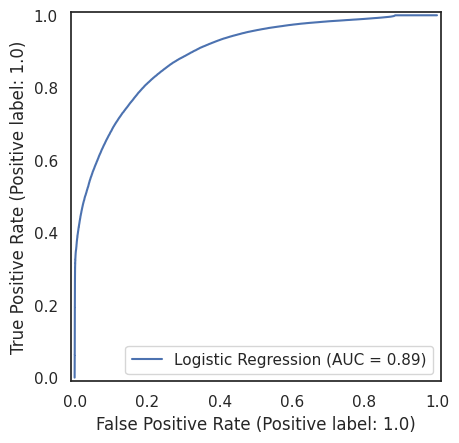

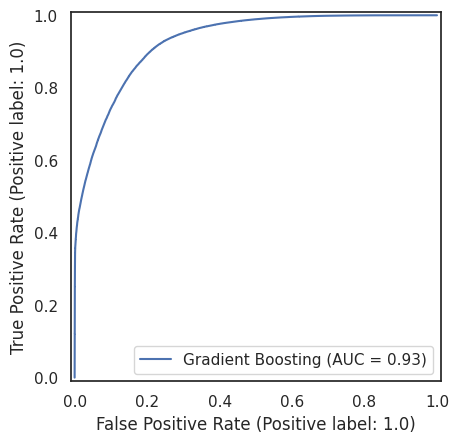

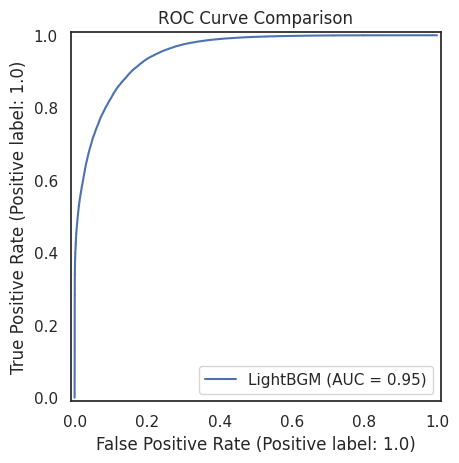

Top SHAP feature importances for Logistic Regression


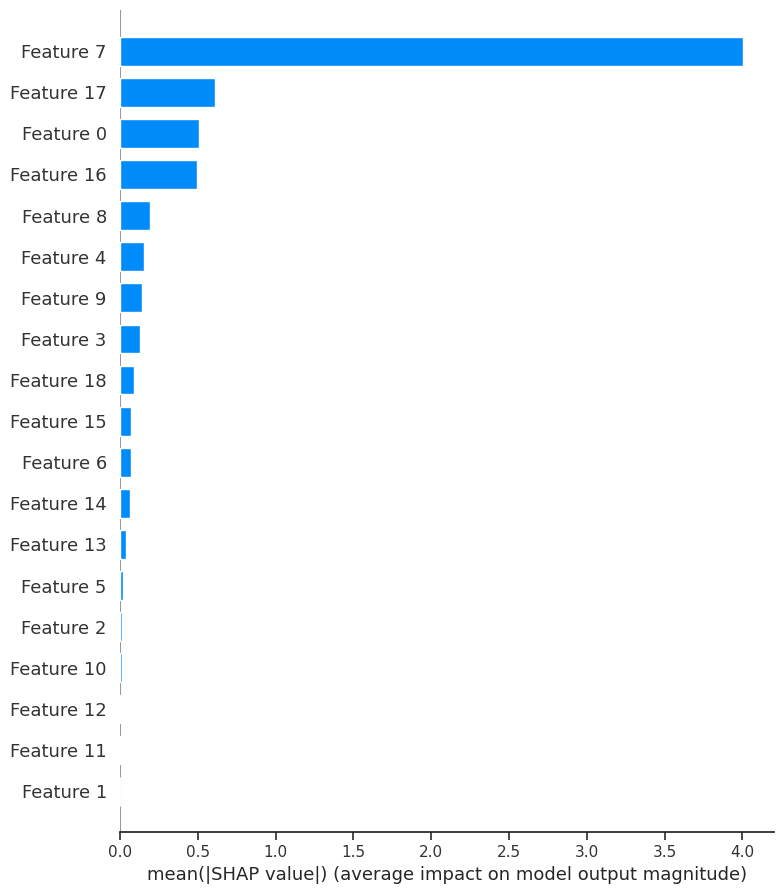

Top SHAP feature importances for Gradient Boosting


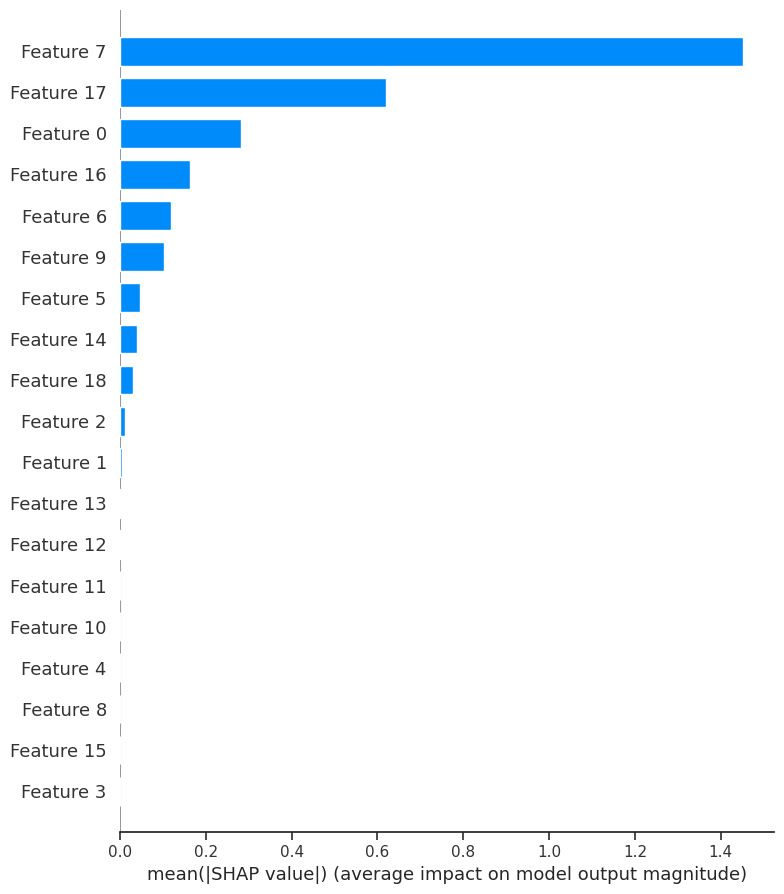

c:\Users\Phuah Kai Wen\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Top SHAP feature importances for LightBGM


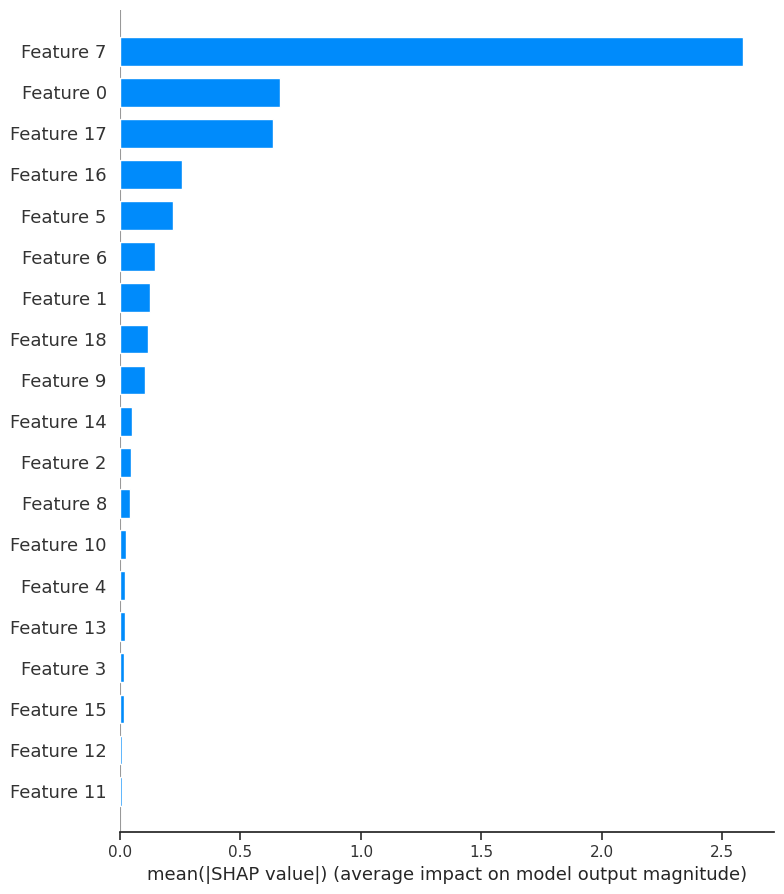

Summary of Results:
                 Model  Accuracy    Recall        F2       AUC
0  Logistic Regression  0.897235  0.980891  0.965509  0.893397
1    Gradient Boosting  0.928339  0.980360  0.972017  0.928659
2             LightBGM  0.941085  0.985418  0.977905  0.950316


In [95]:
lr_model = LogisticRegression(random_state = 42)
lr_model.fit(X_train_selected, Y_train)

gb_model = GradientBoostingClassifier(n_estimators = 100, random_state = 42)
gb_model.fit(X_train_selected, Y_train)

lgbm_model = LGBMClassifier(n_estimators = 500, random_state = 42, learning_rate = 0.05, max_depth = 6)
lgbm_model.fit(X_train_selected, Y_train)


# Update the evaluation code to include all four models
results = []
results.append(evaluate_model(lr_model, X_test_selected, Y_test, "Logistic Regression"))
results.append(evaluate_model(gb_model, X_test_selected, Y_test, "Gradient Boosting"))
results.append(evaluate_model(lgbm_model, X_test_selected, Y_test, "LightBGM"))

# Plot ROC Curves for all models
plt.figure(figsize=(4, 4))
RocCurveDisplay.from_estimator(lr_model, X_test_selected, Y_test, name="Logistic Regression")
RocCurveDisplay.from_estimator(gb_model, X_test_selected, Y_test, name="Gradient Boosting")
RocCurveDisplay.from_estimator(lgbm_model, X_test_selected, Y_test, name = "LightBGM")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")  
plt.show()

shap_explanations(lr_model, X_test_selected, "Logistic Regression")
shap_explanations(gb_model, X_test_selected, "Gradient Boosting")
shap_explanations(lgbm_model, X_test_selected, "LightBGM")

# Summarize the results in a DataFrame

results_df = pd.DataFrame(results)
print("Summary of Results:")
print(results_df)


In [96]:
import joblib

joblib.dump(lgbm_model, "lgbm_model.pkl")
joblib.dump(selected_features_names, "selected_features.pkl")

['selected_features.pkl']